In [2]:
# authors : Guillaume Lemaitre <g.lemaitre58@gmail.com>
# license : MIT

from os.path import dirname, join
from os import listdir
from pprint import pprint

import pydicom
import cv2

from pydicom.filereader import read_dicomdir


import matplotlib.pyplot as plt
import numpy as np
import scipy

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage.segmentation import clear_border
from scipy import ndimage as ndi
from skimage.filters import roberts, sobel


# fetch the path to the test data
#filepath = get_testdata_files('DICOMDIR')[0]



filepath = '/Users/ICI/Documents/CACS_from_kaggle_model/data/CRE_104-1008-CT-01-6298993355423/DICOMDIR'
#annot_dicom = '../OsiriX_annotations/Cre_102-1001'

#### 1. Read DICOM directory

Taken from the pydicom repository

This is to read calcium scoring CTs

In [3]:
"""
====================
Read DICOM directory
====================
This example shows how to read DICOM directory.
"""

def load_patient(src_dir):
    slices = [pydicom.read_file(src_dir + '/' + s) for s in os.listdir(src_dir)]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness
    return slices



print('Path to the DICOM directory: {}'.format(filepath))
# load the data
dicom_dir = read_dicomdir(filepath)
base_dir = dirname(filepath)

# go through the patient record and print information
for patient_record in dicom_dir.patient_records:
    if (hasattr(patient_record, 'PatientID') and
            hasattr(patient_record, 'PatientsName')):
        print("Patient: {}: {}".format(patient_record.PatientID,
                                       patient_record.PatientsName))
    studies = patient_record.children
    # got through each serie
    for study in studies:
        print(" " * 4 + "Study {}: {}: {}".format(study.StudyID,
                                                  study.StudyDate,
                                                  study.StudyDescription))
        all_series = study.children

        
        # go through each serie
        for series in all_series:

            image_count = len(series.children)
            plural = ('', 's')[image_count > 1]

            # Write basic series info and image count

            # Put N/A in if no Series Description
            if 'SeriesDescription' not in series:
                series.SeriesDescription = "N/A"
            print(" " * 8 + "Series {}: {}: {} ({} image{})".format(
                series.SeriesNumber, series.Modality, series.SeriesDescription,
                image_count, plural))

            # Open and read something from each image, for demonstration
            # purposes. For simple quick overview of DICOMDIR, leave the
            # following out
#            print(" " * 12 + "Reading images...")
#            image_records = series.children
#            image_filenames = [join(base_dir, *image_rec.ReferencedFileID)
#                               for image_rec in image_records]
#
#            datasets = [pydicom.dcmread(image_filename)
#                        for image_filename in image_filenames]
#
#            patient_names = set(ds.PatientName for ds in datasets)
#            patient_IDs = set(ds.PatientID for ds in datasets)
#
#            # List the image filenames
#            print("\n" + " " * 12 + "Image filenames:")
#            print(" " * 12, end=' ')
#            pprint(image_filenames, indent=12)
#
#            # Expect all images to have same patient name, id
#            # Show the set of all names, IDs found (should each have one)
#            print(" " * 12 + "Patient Names in images..: {}".format(
#                patient_names))
#            print(" " * 12 + "Patient IDs in images..: {}".format(
#                patient_IDs))
            
            if '3.0' in series.SeriesDescription:
                calcium_CT = series
                print('Series {} is a Calcium Score CT'.format(series.SeriesNumber))
                
                

print("Reading calcium score CT...")                

series = calcium_CT
print(" " * 12 + "Reading images...")
image_records = series.children

#image_filenames = [join(base_dir, *image_rec.ReferencedFileID) + image_rec.ReferencedFileID[1]
#                   for image_rec in image_records]
image_filenames = [join(base_dir, *image_rec.ReferencedFileID)
                   for image_rec in image_records]

datasets = [pydicom.dcmread(image_filename)
            for image_filename in image_filenames]

patient_names = set(ds.PatientName for ds in datasets)
patient_IDs = set(ds.PatientID for ds in datasets)

print("Check number of slices: {}".format(
    len(image_filenames)))
print("Check series number: {}".format(
    series.SeriesNumber))




def load_scan():
    slices = [pydicom.read_file(file) for file in image_filenames]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices


# taken from Kaggle
def plot_3d(image, step_size=1, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    #p = p[:,:,::-1]
    #p = np.array([image[1], image[2], image[0]])

    verts, faces, _, _ = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    ax.set_axis_bgcolor((0.7, 0.7, 0.7))

    plt.show()
    
   
def get_numpy_img(slices):
    slices = np.stack([s.pixel_array for s in slices])
    slices[slices == -2000] = 0
    return slices    
    
    
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)


def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing

    #spacing = np.array([scan[0].SliceThickness, scan[0].SliceThickness]+scan[0].PixelSpacing, dtype=np.float32)
    ## New pydicom version
    spacing = np.array([scan[0].SliceThickness, scan[0].PixelSpacing[0], scan[0].PixelSpacing[1]], dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing



first_patient = load_scan()

first_patient_pixels = get_pixels_hu(first_patient)

pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

#plot_3d(pix_resampled, -1000)



Path to the DICOM directory: /Users/ICI/Documents/CACS_from_kaggle_model/data/CRE_104-1008-CT-01-6298993355423/DICOMDIR
    Study  : 20151028: 
        Series 1: CT:   2.0 (2 images)
        Series 3: CT: HALF 75% 1.08s Cardiac 0.5  (320 images)
        Series 4: CT: HALF 75% 1.08s Cardiac 3.0  (54 images)
Series 4 is a Calcium Score CT
        Series 5: CT: HALF 75% 1.05s Cardiac 0.5 CE (320 images)
Reading calcium score CT...
            Reading images...
Check number of slices: 54
Check series number: 4
Shape before resampling	 (54, 512, 512)
Shape after resampling	 (162, 200, 200)


#### 2. Plotting one slice with matplotlib

Plotting 1 slice with matplotlib
Image size.......: 512 x 512, 524288 bytes
Pixel spacing....: ['0.390000', '0.390000']
Slice location...: 149.750


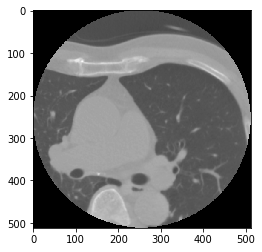

In [4]:
print("Plotting 1 slice with matplotlib")


dataset = pydicom.dcmread(image_filenames[10])

if 'PixelData' in dataset:
    rows = int(dataset.Rows)
    cols = int(dataset.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dataset.PixelData)))
    if 'PixelSpacing' in dataset:
        print("Pixel spacing....:", dataset.PixelSpacing)

# use .get() if not sure the item exists, and want a default value if missing
print("Slice location...:", dataset.get('SliceLocation', "(missing)"))

# plot the image using matplotlib
plt.imshow(dataset.pixel_array, cmap=plt.cm.gray)
plt.show()


#### 3. Getting CAC candidates

Inspired by nodule detection on Kaggle


In [5]:
def get_CAC_candidate(im, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(4, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. Threshold 130 HU
    '''
    binary = im > 130
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 

    '''
    Step 3: Label the image.
    '''
    label_image = measure.label(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(label_image, cmap=plt.cm.bone) 
 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = morphology.disk(2)
    binary = morphology.binary_erosion(binary, selem)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(binary, cmap=plt.cm.bone) 

    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(im, cmap=plt.cm.bone) 
        
    return im

In [6]:
imgs = get_numpy_img(first_patient)
masks = []


#im, binary = get_segmented_heart_2(imgs[20], plot=True, plot_progress=True)


NameError: name 'get_segmented_heart_2' is not defined

#### 4. Unsupervised heart segmentation

In [7]:


# def get_segmented_heart(im, plot=False):
#     if plot == True:
#         f, plots = plt.subplots(5, 1, figsize=(5, 40))
#     # Step 1: Convert into a binary image.
#     binary = im > im.mean()
#     if plot == True:
#         plots[0].axis('off')
#         plots[0].imshow(binary, cmap=plt.cm.gray) 
#     # Step 3: Label the image.
#     label_image = measure.label(binary)
#     # Step 4: Keep the label with largest area.
#     areas = [r.area for r in measure.regionprops(label_image)]
#     areas.sort()
#     if len(areas) > 1:
#         for region in measure.regionprops(label_image):
#             if region.area < areas[-1]:
#                 for coordinates in region.coords:
#                        label_image[coordinates[0], coordinates[1]] = 0
#     binary = label_image > 0
#     if plot == True:
#         plots[1].axis('off')
#         plots[1].imshow(label_image, cmap=plt.cm.gray) 
#     # Step 5: Erosion operation with a disk of radius 2. This operation is seperate the lung nodules from the heart
#     selem = morphology.disk(10)
#     binary = morphology.binary_erosion(binary, selem)
#     if plot == True:
#         plots[2].axis('off')
#         plots[2].imshow(binary, cmap=plt.cm.gray) 

#     # Step 7: Fill in the small holes inside the binary mask of lungs.
#     edges = roberts(binary)
#     binary = ndi.binary_fill_holes(edges)
#     if plot == True:
#         plots[3].axis('off')
#         plots[3].imshow(im, cmap=plt.cm.gray) 
#     # Step 8: Superimpose the binary mask on the input image.
#     get_high_vals = binary == 0
#     im[get_high_vals] = -2000
#     if plot == True:
#         plots[4].axis('off')
#         plots[4].imshow(im, cmap=plt.cm.gray) 
#     return im, binary





# my Python implementation of Jorge Larrey-Ruiz et al: https://link.springer.com/content/pdf/10.1186%2F1687-5281-2014-52.pdf

def get_segmented_heart(im, plot=False, plot_progress=False):

    if plot == True:
        plt.imshow(im, cmap=plt.cm.gray)
        plt.show()
    
    N, M = im.shape
    
    w_mean = 0.1*N
    w_max = 0.3*N
    
    binary = im > im.mean()
    
    for j in range(M):
        profile_j = binary[::,j]
        
        ## Compute w_j the width of leftmost pulse
        
        try:
            w_j_min = np.where(profile_j)[0][0]
            w_j_max = w_j_min
            while profile_j[w_j_max]:
                w_j_max +=1
            w_j = w_j_max - w_j_min
        except IndexError:
            w_j = 0
        
        if w_j < w_max:
            w_mean = w_j
            
        ## Remove the upmost w_mean pixels with value 1

        cnt = 0
        i = 0
        while cnt < w_mean:
            if binary[i,j]: 
                binary[i,j] = False
                cnt += 1
            i += 1
        
        if plot_progress == True:
            plt.imshow(binary, cmap=plt.cm.gray)
            plt.show()
    
    # Final step: Keep the label with largest area.
    label_image = measure.label(binary)
    areas = [r.area for r in measure.regionprops(label_image)]
    areas.sort()
    if len(areas) > 1:
        for region in measure.regionprops(label_image):
            if region.area < areas[-1]:
                for coordinates in region.coords:
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plt.imshow(binary, cmap=plt.cm.gray) 
        
    get_high_vals = binary == 0
    im[get_high_vals] = -2000
    
    if plot == True:
        plt.imshow(im, cmap=plt.cm.gray)
        plt.show()
    return im, binary
            



def test_contours(im):
    imgray = im < 604
    ret,thresh = cv2.threshold(imgray,127,255,0)
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(im2, contours, -1, (0,255,0), 3)
    
#test_contours(im[10])

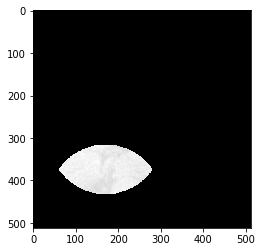

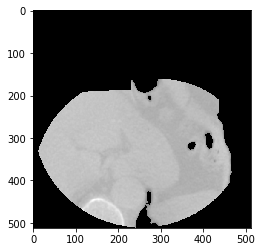

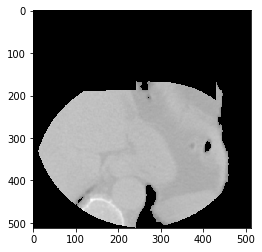

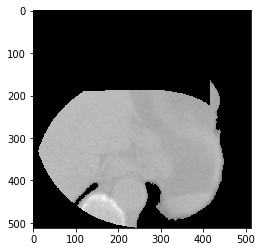

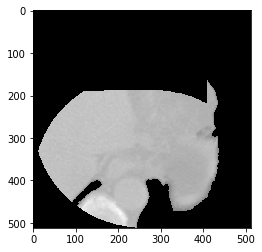

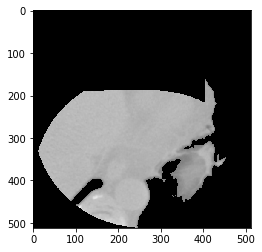

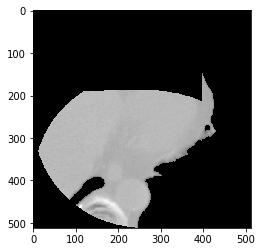

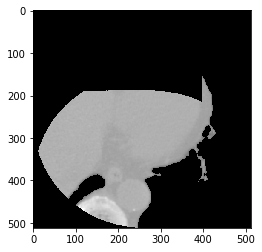

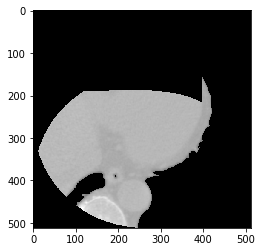

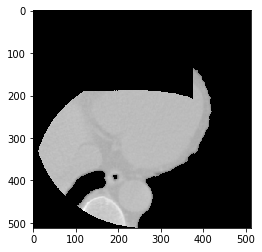

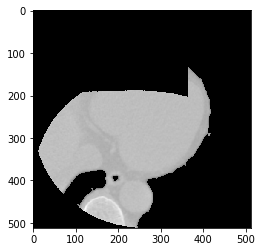

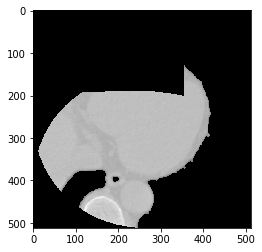

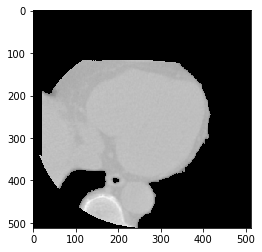

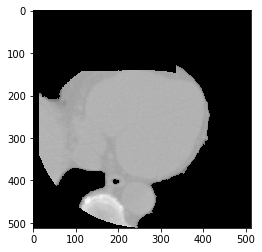

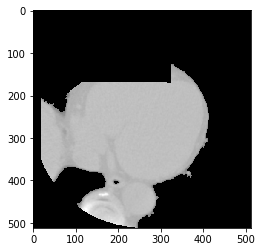

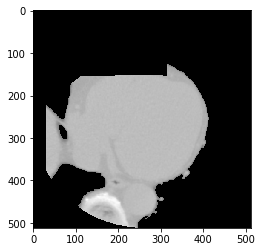

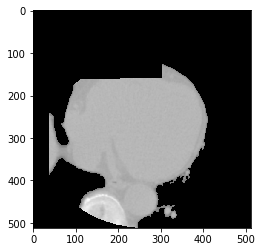

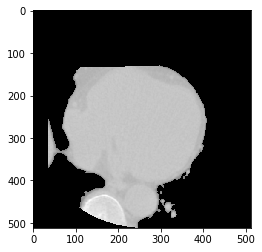

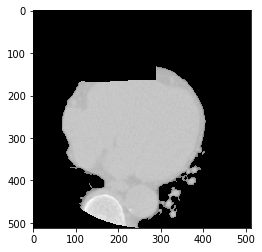

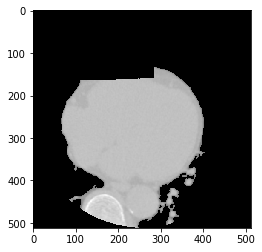

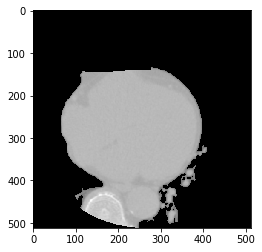

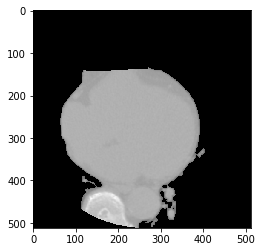

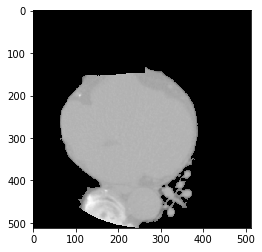

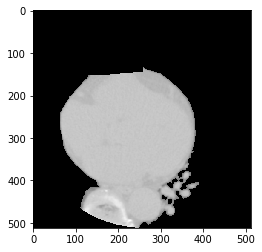

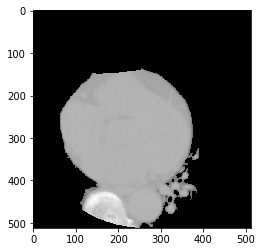

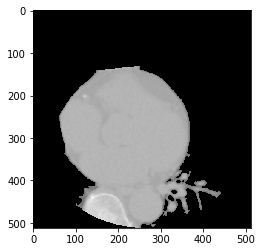

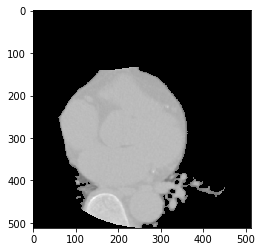

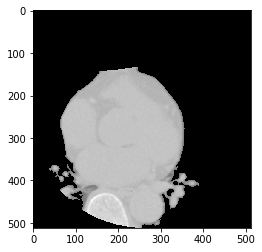

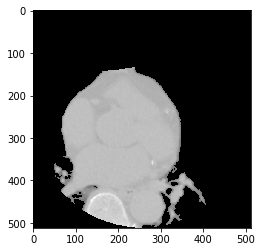

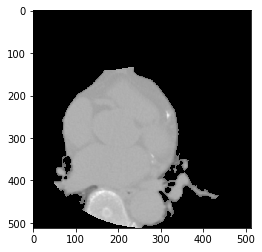

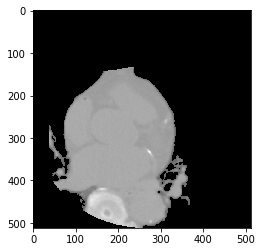

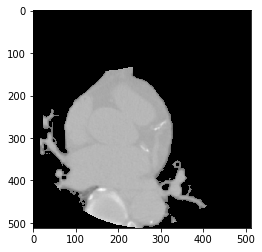

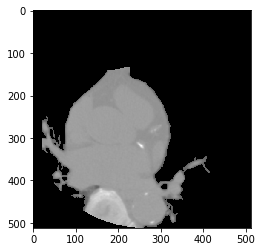

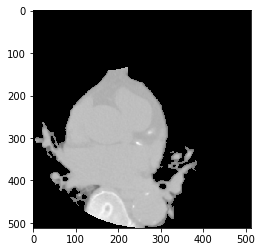

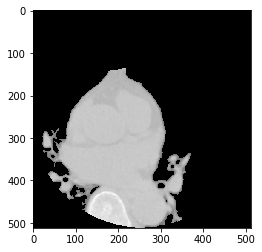

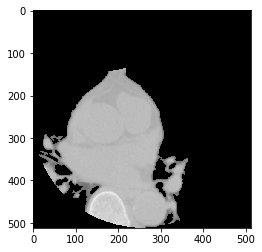

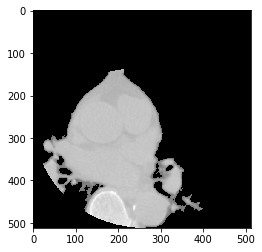

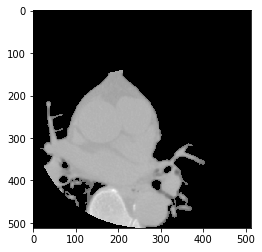

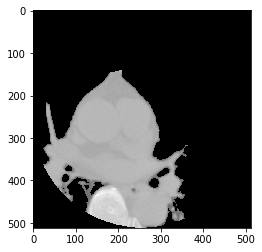

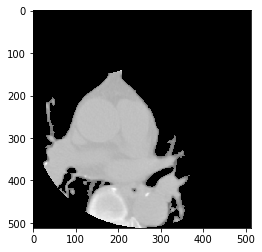

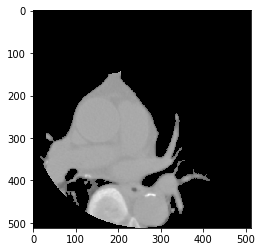

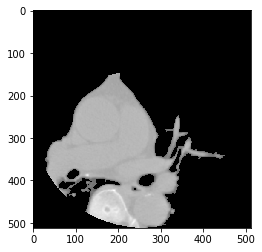

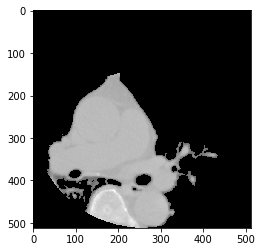

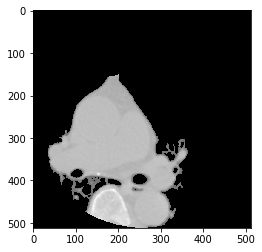

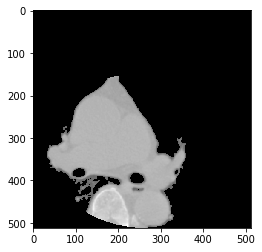

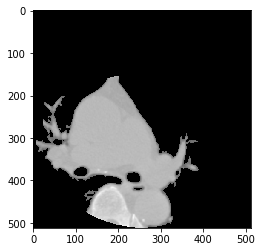

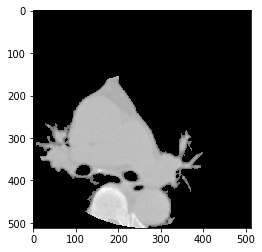

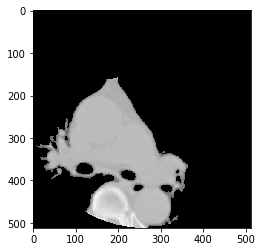

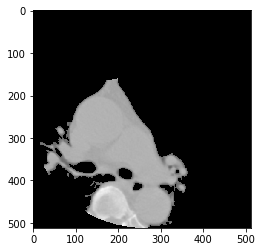

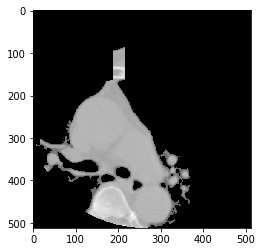

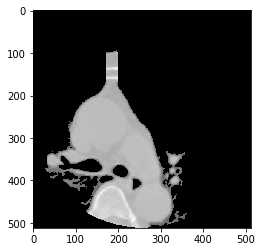

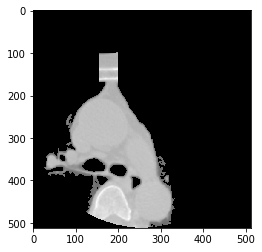

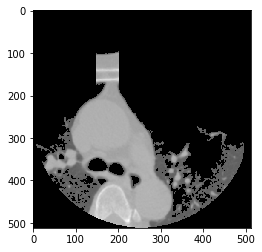

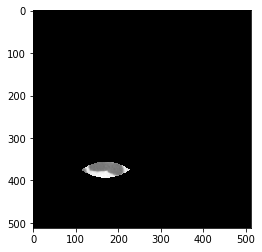

In [8]:
for i in range(len(imgs)):
    im = imgs[i]
    masks.append(get_segmented_heart(im, False))
    get_high_vals = masks[i] == 0
    im[get_high_vals] = 0
    plt.imshow(im, cmap=plt.cm.gray)
    plt.show()